# Data Exploration

The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders.

File descriptions
Each entity (customer, product, order, aisle, etc.) has an associated unique id. Most of the files and variable names should be self-explanatory.

### aisles.csv
> aisle_id,aisle  
 1,prepared soups salads  
 2,specialty cheeses  
 3,energy granola bars  
 ...
 
### departments.csv
> department_id,department  
 1,frozen  
 2,other  
 3,bakery  
 ...
 
### order_products__*.csv
These files specify which products were purchased in each order. order_products__prior.csv contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items. You may predict an explicit 'None' value for orders with no reordered items. See the evaluation page for full details.
> order_id,product_id,add_to_cart_order,reordered  
 1,49302,1,1  
 1,11109,2,1  
 1,10246,3,0  
 ... 
 
### orders.csv
This file tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders. 'order_dow' is the day of week.
> order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order  
 2539329,1,prior,1,2,08,  
 2398795,1,prior,2,3,07,15.0  
 473747,1,prior,3,3,12,21.0  
 ...
 
### products.csv
> product_id,product_name,aisle_id,department_id
 1,Chocolate Sandwich Cookies,61,19  
 2,All-Seasons Salt,104,13  
 3,Robust Golden Unsweetened Oolong Tea,94,7  
 ...

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [21]:
order_products_train_df = pd.read_csv("data/order_products__train.csv")
order_products_prior_df = pd.read_csv("data/order_products__prior.csv")
orders_df = pd.read_csv("data/orders.csv")
products_df = pd.read_csv("data/products.csv")
aisles_df = pd.read_csv("data/aisles.csv")
departments_df = pd.read_csv("data/departments.csv")

In [22]:
print(f"Dimensions of data frame: {orders_df.shape} \n")
orders_df.head()

Dimensions of data frame: (3421083, 7) 



,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [23]:
print(f"Dimensions of data frame: {order_products_prior_df.shape} \n")
order_products_prior_df.head()

Dimensions of data frame: (32434489, 4) 



,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [24]:
print(f"Dimensions of data frame: {order_products_train_df.shape} \n")
order_products_train_df.head()

Dimensions of data frame: (1384617, 4) 



,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [25]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
print("Unique Customers per set")
cnt_srs

Unique Customers per set


eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

How many times have customers ordered?


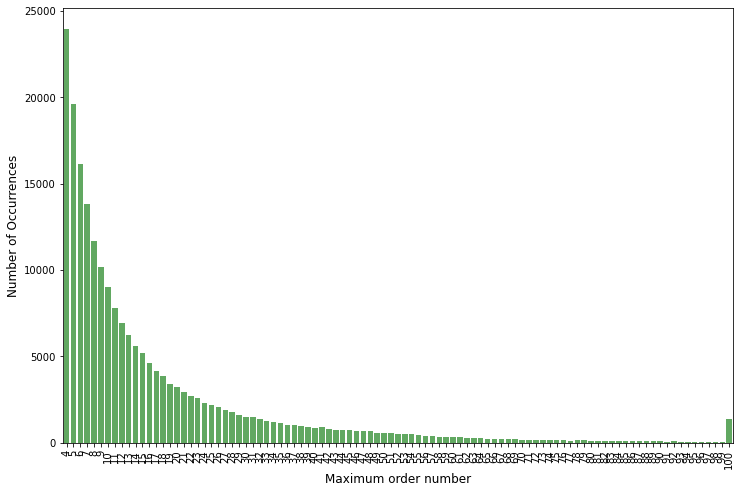

In [28]:
print("How many times have customers ordered?")
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
fig = plt.gcf()
fig.savefig('images/number_of_times_customers_ordered.png')
plt.show()

How many orders per week day? (0 and 1 is Saturday and Sunday)


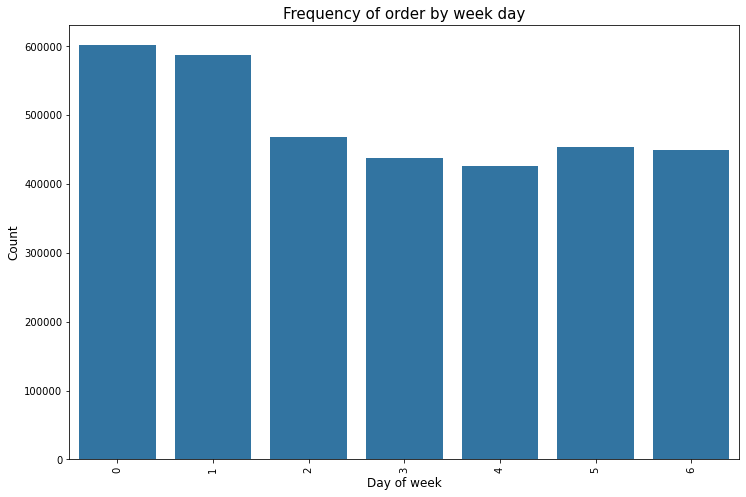

In [29]:
print("How many orders per week day? (0 and 1 is Saturday and Sunday)")
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
fig = plt.gcf()
fig.savefig('images/number_of_orders_per_week_day.png')
plt.show()

When have customers ordered?


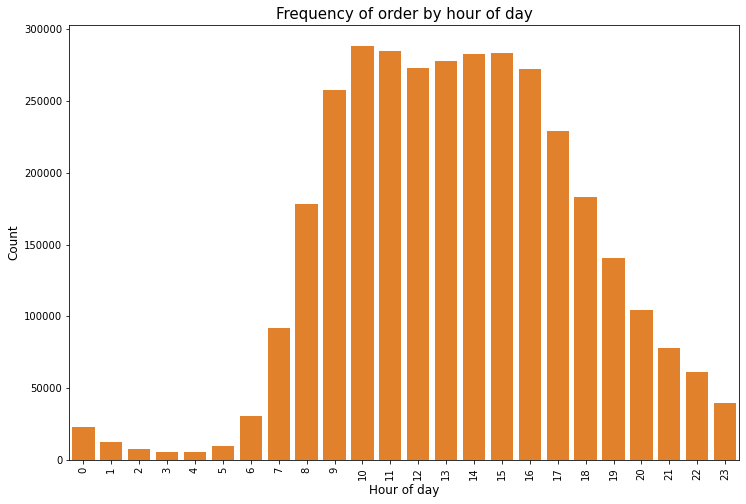

In [30]:
print("When have customers ordered?")
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
fig = plt.gcf()
fig.savefig('images/number_of_orders_per_hour_of_day.png')
plt.show()

## Merging Prior and Train

In [11]:
order_products_df = pd.concat(
    [order_products_train_df, order_products_prior_df]
)
print(f"Dimensions of merged data frame: {order_products_df.shape} \n")

Dimensions of merged data frame: (33819106, 4) 



How many products were bought in each order?


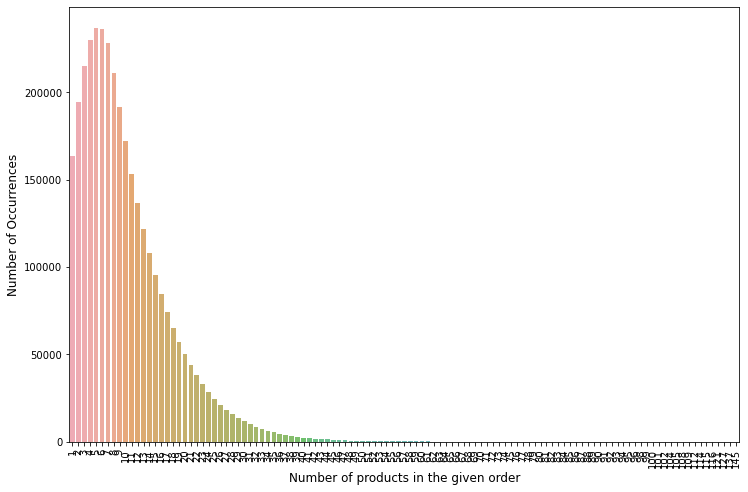

In [31]:
print("How many products were bought in each order?")
grouped_df = order_products_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
fig = plt.gcf()
fig.savefig('images/number_of_products_per_order.png')
plt.show()

In [13]:
print(f"Dimensions of data frame: {products_df.shape} \n")
products_df.head()

Dimensions of data frame: (49688, 4) 



,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [14]:
print(f"Dimensions of data frame: {aisles_df.shape} \n")
aisles_df.head()

Dimensions of data frame: (134, 2) 



,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [15]:
print(f"Dimensions of data frame: {departments_df.shape} \n")
departments_df.head()

Dimensions of data frame: (21, 2) 



,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


### Merging the order data with the product, aisle and department data

In [16]:
order_products_df = pd.merge(order_products_df, products_df, on='product_id', how='left')
order_products_df = pd.merge(order_products_df, aisles_df, on='aisle_id', how='left')
order_products_df = pd.merge(order_products_df, departments_df, on='department_id', how='left')
order_products_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


In [17]:
print("Which products were bought the most often?")
cnt_srs = order_products_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

Which products were bought the most often?


,product_name,frequency_count
0,Banana,491291
1,Bag of Organic Bananas,394930
2,Organic Strawberries,275577
3,Organic Baby Spinach,251705
4,Organic Hass Avocado,220877
5,Organic Avocado,184224
6,Large Lemon,160792
7,Strawberries,149445
8,Limes,146660
9,Organic Whole Milk,142813


Which aisles are most popular?


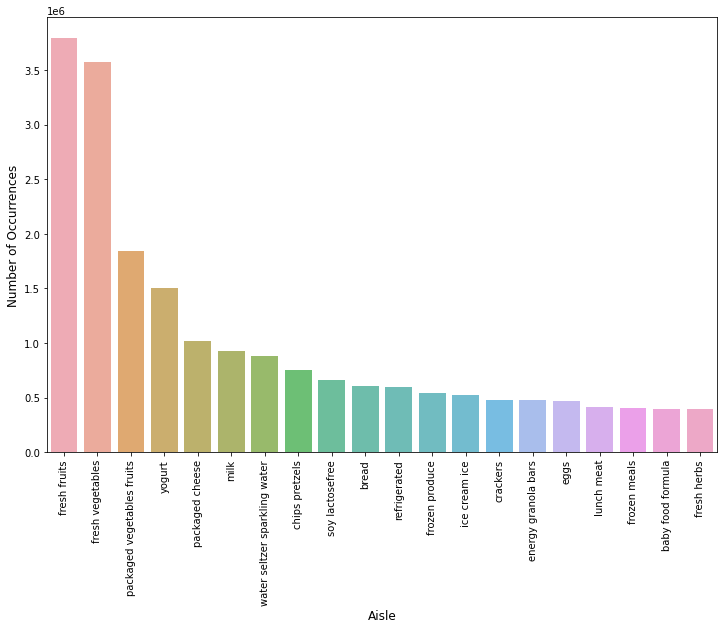

In [34]:
print("Which aisles are most popular?")
cnt_srs = order_products_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
fig = plt.gcf()
fig.savefig('images/most_popular_aisles.png')
plt.show()

What is the department distribution?


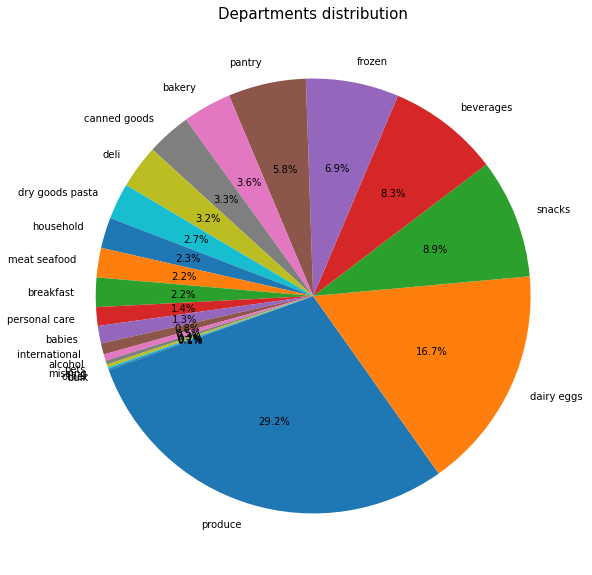

In [35]:
print("What is the department distribution?")
fig = plt.figure(figsize=(10,10))
temp_series = order_products_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
fig.set_facecolor('white')
fig = plt.gcf()
fig.savefig('images/departments_distribution.png')
plt.show()